In [1]:
# 1. IMPORTS
import tensorflow as tf
from tensorflow.keras import layers, models,Input
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from sklearn.utils import shuffle
from tensorflow import keras
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split

In [2]:
# 2. SETUP PATHS & CONFIG
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
TRAIN_DIR = '/content/drive/MyDrive/cvprFaceDataset/newdata/train'
TEST_DIR  = '/content/drive/MyDrive/cvprFaceDataset/newdata/test'

class_names = ['nadim', 'marowa', 'mehedi', 'bikash', 'unknown']
IMG_SIZE = 224

In [4]:
face_cascade = cv2.CascadeClassifier(
    cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'
)

def load_faces(base_dir):
    X, y = [], []
    print("Loading faces...")

    for label, person in enumerate(class_names):
        person_dir = os.path.join(base_dir, person)
        if not os.path.isdir(person_dir):
            continue

        for img_name in os.listdir(person_dir):
            img = cv2.imread(os.path.join(person_dir, img_name))
            if img is None:
                continue

            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            faces = face_cascade.detectMultiScale(gray, 1.3, 5)

            if len(faces) == 0:
                continue

            x, y_, w, h = faces[0]
            if w < 20 or h < 20: continue
            face = img[y_:y_+h, x:x+w]
            if face.size == 0:
                continue
            face = cv2.resize(face, (IMG_SIZE, IMG_SIZE))

            X.append(face)
            y.append(label)

    return np.array(X), np.array(y)

# Load datasets
X_train, Y_train = load_faces(TRAIN_DIR)
X_test,  Y_test  = load_faces(TEST_DIR)


Loading faces...
Loading faces...


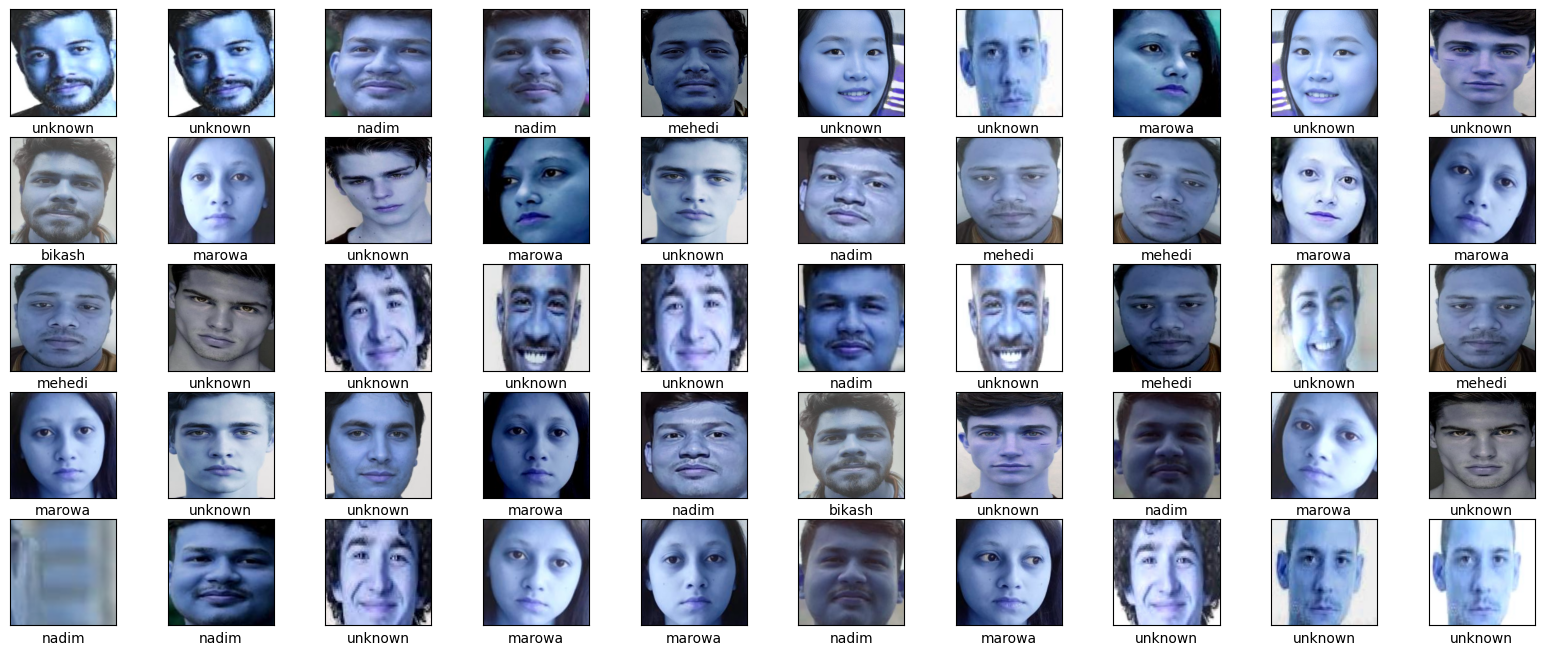

In [5]:
# 2. PLOT images
X_train, Y_train = shuffle(X_train, Y_train, random_state=42)

plt.figure(figsize=(20,8))
limit = min(50, len(X_train))

for i in range(limit):
    plt.subplot(5, 10, i+1)
    plt.imshow(X_train[i])
    plt.xticks([])
    plt.yticks([])
    plt.xlabel(class_names[Y_train[i]])
plt.show()

In [6]:
X_train = preprocess_input(X_train)
X_test  = preprocess_input(X_test)
X_train, Y_train = shuffle(X_train, Y_train, random_state=42)
print(f"\nFinal Shapes -> X_train: {X_train.shape}, Y_train: {Y_train.shape}")


Final Shapes -> X_train: (856, 224, 224, 3), Y_train: (856,)


In [7]:
base_model = MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)
base_model.trainable = False

model = models.Sequential([
    tf.keras.layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3)),

    base_model,

    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(5, activation='softmax')
])

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,597 (9.24 MB)

 Trainable params: 164,613 (643.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [8]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,597 (9.24 MB)

 Trainable params: 164,613 (643.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [9]:
h= model.fit(
    x=X_train, y=Y_train,
    epochs=20,
    validation_split=0.3,
    batch_size=32

)



Epoch 1/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step - accuracy: 0.2322 - loss: 1.9535 - val_accuracy: 0.6576 - val_loss: 1.1082
Epoch 2/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.5499 - loss: 1.1610 - val_accuracy: 0.7821 - val_loss: 0.8113
Epoch 3/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.6976 - loss: 0.8592 - val_accuracy: 0.8599 - val_loss: 0.6262
Epoch 4/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.7968 - loss: 0.6604 - val_accuracy: 0.9027 - val_loss: 0.5105
Epoch 5/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.8368 - loss: 0.5838 - val_accuracy: 0.9261 - val_loss: 0.4357
Epoch 6/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.8604 - loss: 0.4915 - val_accuracy: 0.9377 - val_loss: 0.3634
Epoch 7/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.8702 - loss: 0.4504 - val_accuracy: 0.9416 - val_loss: 0.3165
Epoch 8/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 0.9217 - loss: 0.3404 - val_accuracy: 0.9455 - va

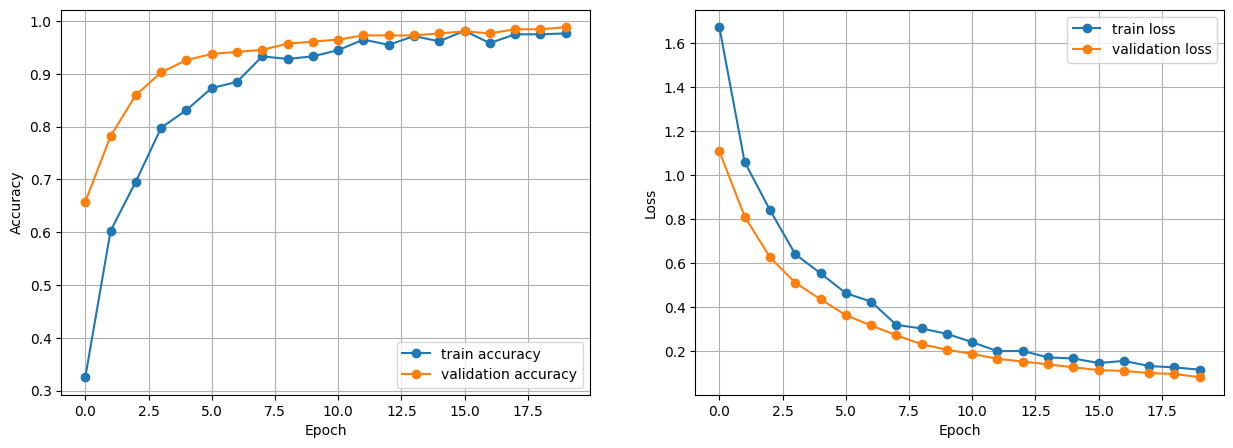

In [10]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(h.history['accuracy'], 'o-', label='train accuracy')
plt.plot(h.history['val_accuracy'], 'o-', label = 'validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend(loc='lower right')

plt.subplot(1,2,2)
plt.plot(h.history['loss'], 'o-', label='train loss')
plt.plot(h.history['val_loss'], 'o-', label='validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend(loc='upper right')

plt.show()

In [11]:
test_loss, test_acc = model.evaluate(X_test, Y_test)
print('\nTest Accuracy:', test_acc)
print('\nTest Loss:', test_loss)

1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step - accuracy: 1.0000 - loss: 0.0381

Test Accuracy: 1.0

Test Loss: 0.038147930055856705


In [12]:
predictions = model.predict(X_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


In [13]:
predictions[1]

array([9.9168164e-01, 1.4593974e-03, 1.4945290e-03, 2.0778301e-04,
       5.1566437e-03], dtype=float32)

In [14]:
np.argmax(predictions[0])

np.int64(0)

In [15]:
model.save("face_attendance_tras_model.keras")
print("Model saved!")

Model saved!


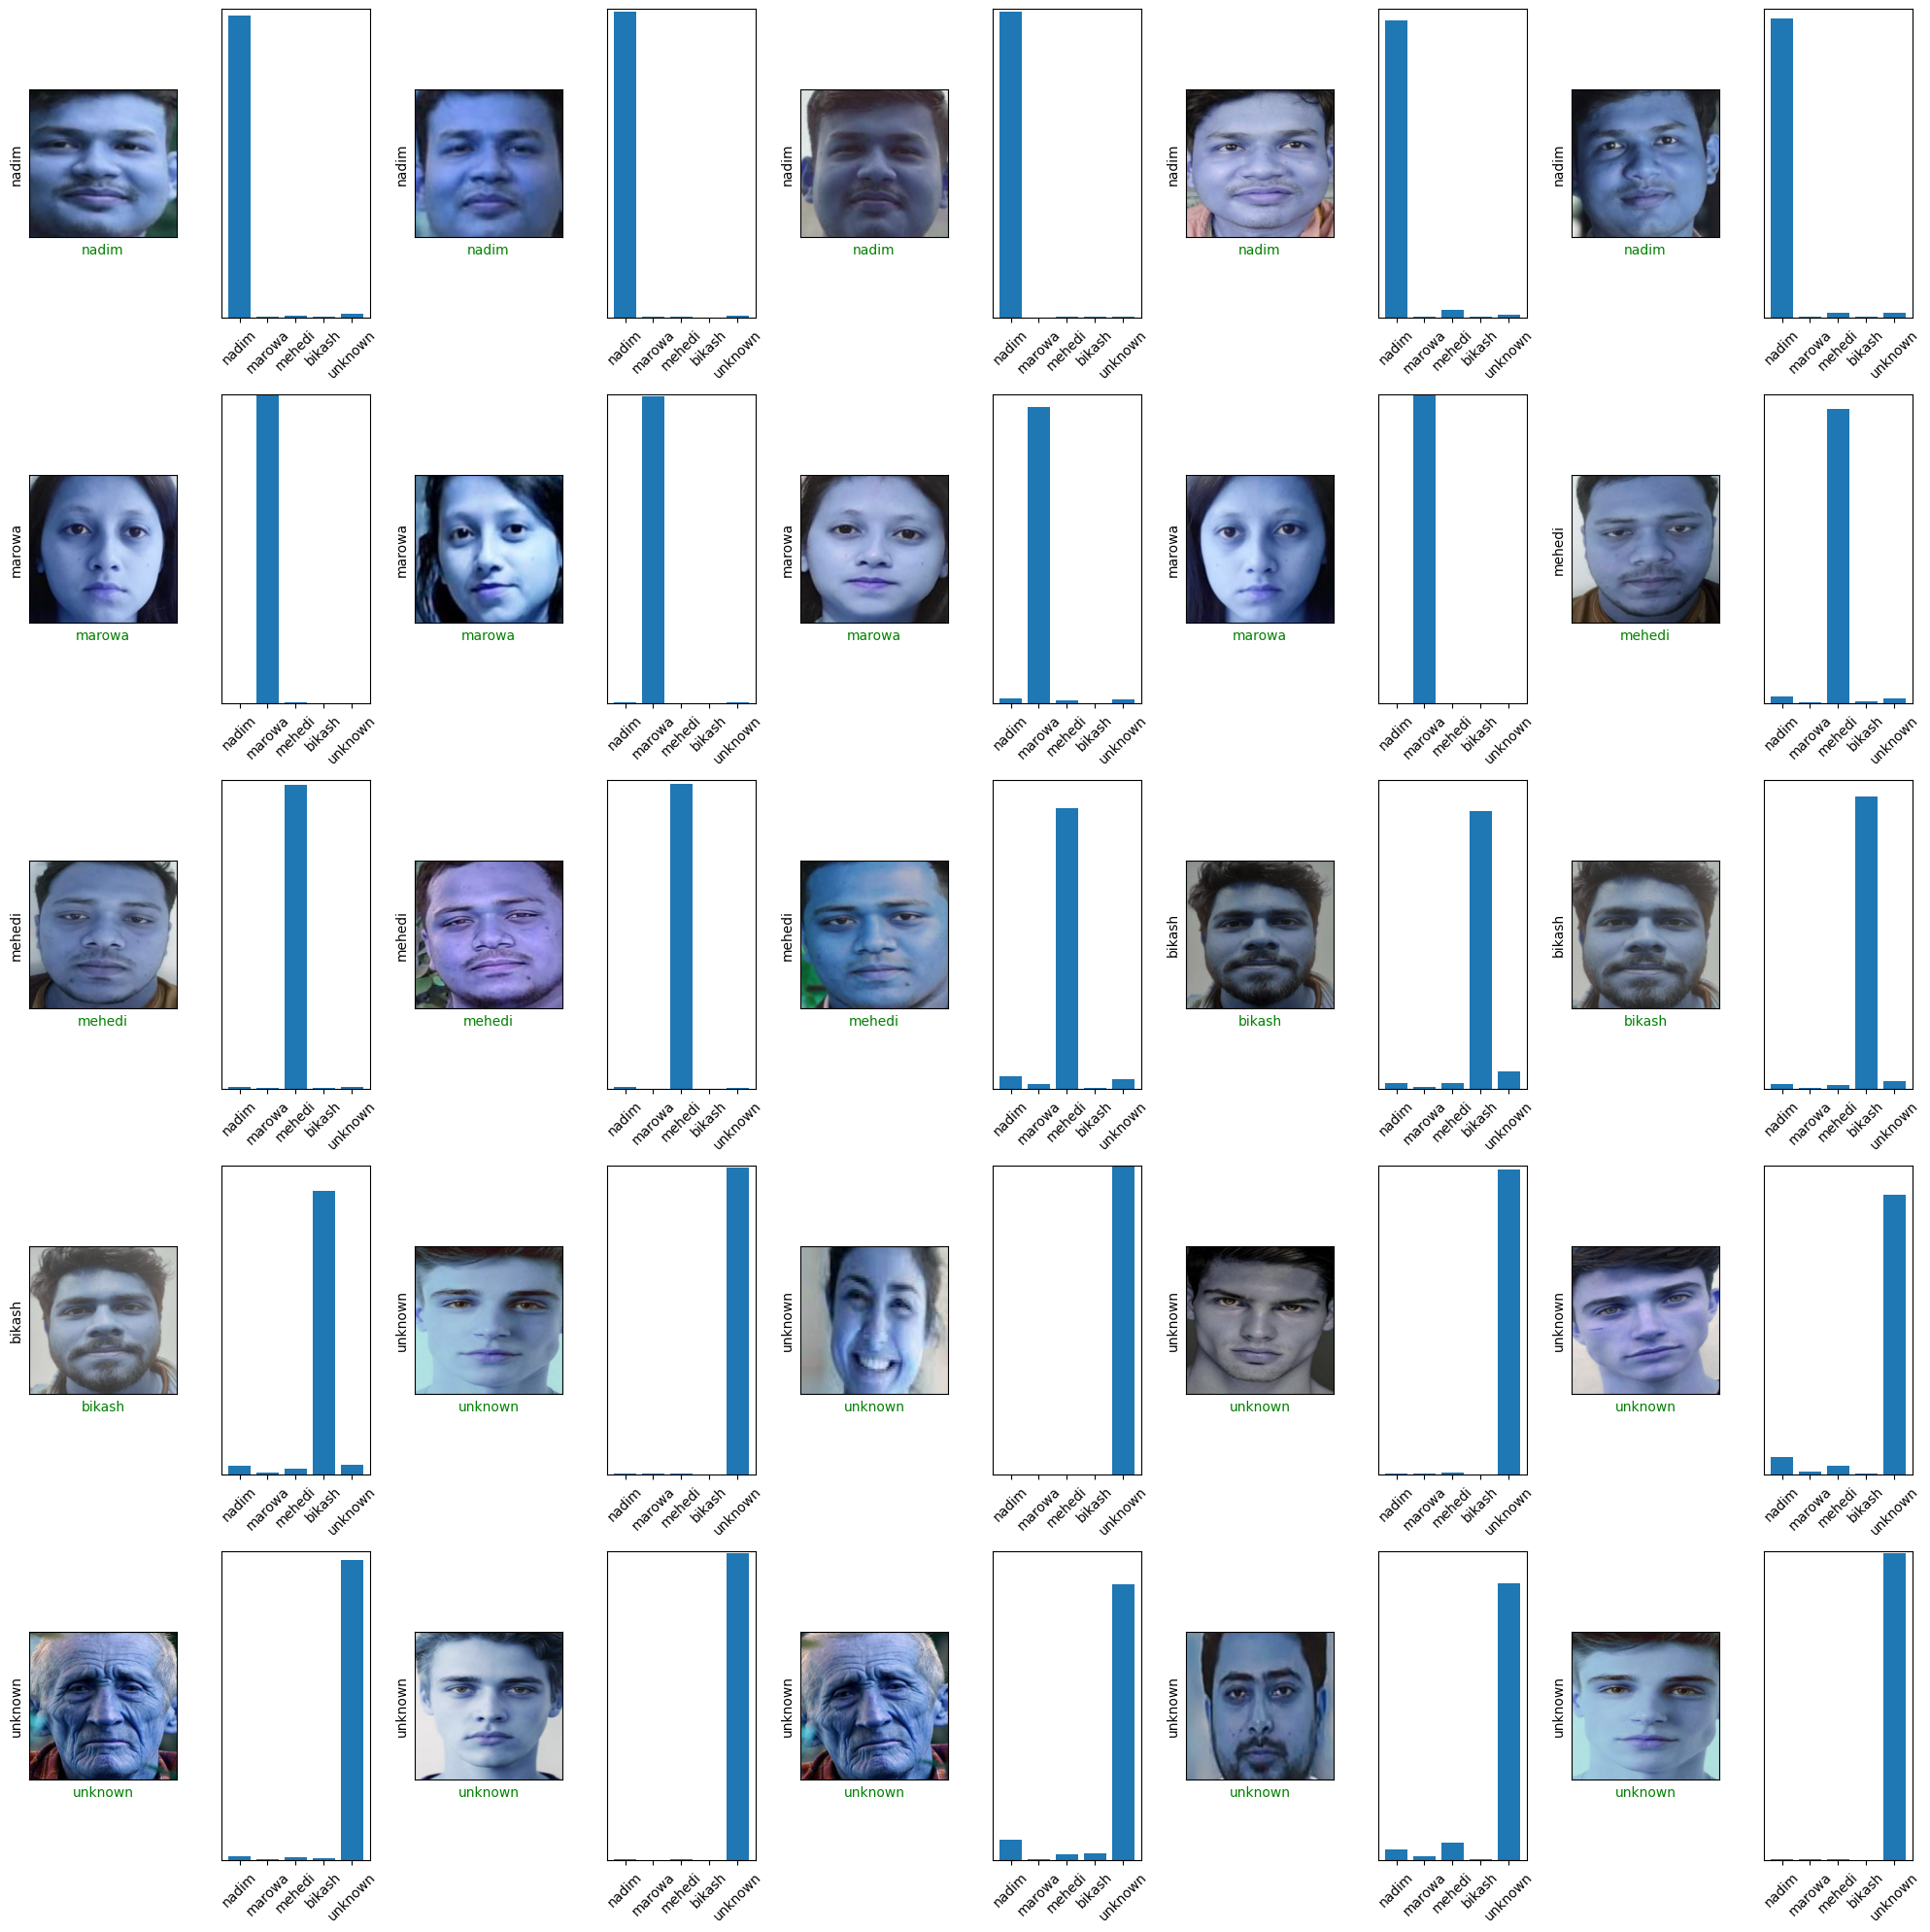

In [16]:
rows = 5
cols = 5
NUM_CLASSES = len(class_names)
def unprocess_image(img):
    return (img + 1.0) / 2.0

plt.figure(figsize=(20,20))
for i in range(rows*cols):
    plt.subplot(rows, 2*cols, 2*i+1)

    display_img = unprocess_image(X_test[i])
    plt.imshow(display_img)

    plt.xticks([])
    plt.yticks([])
    plt.ylabel(class_names[Y_test[i]])

    predicted_label = np.argmax(predictions[i])
    if Y_test[i] == predicted_label:
        plt.xlabel(class_names[predicted_label], color='g')
    else:
        plt.xlabel(class_names[predicted_label], color='r')

    plt.subplot(rows, 2*cols, 2*i+2)
    plt.bar(range(NUM_CLASSES), predictions[i])
    plt.yticks([])
    plt.xticks(range(NUM_CLASSES), class_names, rotation=45)
    plt.ylim([0,1])
    plt.grid(axis='y', linestyle='--', alpha=0.4)

plt.tight_layout()
plt.show()